In [1]:
import pandas as pd
import numpy as np
import sys; sys.path.append("..")
from trader.backtest.pnl import PnL
from trader.strategies.breakout import breakout
from trader.strategies.ewmac import ewmac
from trader.strategies.cp_meanrev import cp_meanrev
from trader.strategies.util import MultiForecast
from trader.data.binance import Binance

In [2]:
b = Binance(test=False)

In [3]:
tickers = b.client.get_ticker()

In [4]:
s = pd.DataFrame(tickers)
s[s.symbol.str.contains("ADA")]

,symbol,priceChange,priceChangePercent,weightedAvgPrice,prevClosePrice,lastPrice,lastQty,bidPrice,bidQty,askPrice,...,openPrice,highPrice,lowPrice,volume,quoteVolume,openTime,closeTime,firstId,lastId,count
171,ADABTC,0.00000023,1.021,0.00002255,0.00002251,0.00002275,194.60000000,0.00002274,2466.00000000,0.00002275,...,0.00002252,0.00002310,0.00002213,15471924.10000000,348.83624766,1661983251466,1662069651466,113937486,113972967,35482
172,ADAETH,-0.00000070,-0.242,0.00028879,0.00028900,0.00028860,385.40000000,0.00028840,7365.00000000,0.00028860,...,0.00028930,0.00029510,0.00028370,3290755.80000000,950.32704392,1661983251046,1662069651046,26719653,26728457,8805
296,ADAUSDT,0.00200000,0.439,0.44966325,0.45570000,0.45760000,22.00000000,0.45760000,10320.20000000,0.45770000,...,0.45560000,0.46240000,0.44070000,129862632.20000000,58394453.13879000,1661983251584,1662069651584,405797308,405939494,142187
297,ADABNB,0.00003300,2.041,0.00162973,0.00161800,0.00165000,463.20000000,0.00165000,6038.50000000,0.00165200,...,0.00161700,0.00167100,0.00159600,1166034.70000000,1900.31650250,1661983239523,1662069639523,13045570,13049093,3524
423,ADATUSD,0.00880000,1.966,0.45206755,0.45500000,0.45650000,94.00000000,0.45710000,1531.60000000,0.45790000,...,0.44770000,0.46120000,0.44440000,186965.30000000,84520.94536000,1661983236181,1662069636181,1204433,1204588,156
485,ADAPAX,0.00000000,0.000,0.00000000,0.03257000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1661661769321,1661748169321,-1,-1,0
486,ADAUSDC,0.00260000,0.571,0.44833348,0.45660000,0.45760000,157.10000000,0.45740000,3226.60000000,0.45780000,...,0.45500000,0.46210000,0.44100000,3077723.00000000,1379846.27313000,1661983244660,1662069644660,5059439,5062357,2919
655,ADABUSD,0.00210000,0.461,0.44958036,0.45550000,0.45760000,1746.00000000,0.45750000,4769.30000000,0.45760000,...,0.45550000,0.46240000,0.44080000,53387730.90000000,24002075.21002000,1661983251611,1662069651611,86860392,86933271,72880
852,ADAUPUSDT,0.00600000,0.649,0.88507462,0.92500000,0.93100000,26.84000000,0.93000000,648.42000000,0.93200000,...,0.92500000,0.95600000,0.84600000,2511154.80000000,2222559.38836000,1661983250130,1662069650130,24856726,24892329,35604
853,ADADOWNUSDT,-0.00007100,-1.507,0.00485281,0.00470700,0.00464100,138548.59000000,0.00464000,2370.68000000,0.00464200,...,0.00471200,0.00504300,0.00452800,354234030.31000000,1719029.83547758,1661983249825,1662069649825,17844371,17868164,23794


In [5]:
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2022-08-15")
bars = b.get_bars(["BTCUSDT", "ETHUSDT", "ETHBTC", "BNBBTC", "ADAUSDT", "BNBETH"], start, end)

In [6]:
bars

,OpenTime,Open,High,Low,Close,Volume,CloseTime,QuoteVolume,NumTrades,TakerBaseVolume,TakerQuoteVolue,Return,Symbol
0,2022-01-01,46216.9300,47954.6300,46208.3700,47722.6500,19604.46325,2022-01-02,9.241552e+08,714899,9942.36679,4.687387e+08,NaN,BTCUSDT
1,2022-01-02,47722.6600,47990.0000,46654.0000,47286.1800,18340.46040,2022-01-03,8.666110e+08,709624,9166.46954,4.331824e+08,-0.009146,BTCUSDT
2,2022-01-03,47286.1800,47570.0000,45696.0000,46446.1000,27662.07710,2022-01-04,1.292204e+09,885624,13524.76045,6.318794e+08,-0.017766,BTCUSDT
3,2022-01-04,46446.1000,47557.5400,45500.0000,45832.0100,35491.41360,2022-01-05,1.649170e+09,1021815,17689.26808,8.217255e+08,-0.013222,BTCUSDT
4,2022-01-05,45832.0100,47070.0000,42500.0000,43451.1300,51784.11857,2022-01-06,2.334289e+09,1478532,23552.99460,1.063287e+09,-0.051948,BTCUSDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,2022-08-11,0.1773,0.1781,0.1700,0.1720,32026.31700,2022-08-12,5.571807e+03,32719,15057.39500,2.621189e+03,-0.029893,BNBETH
1358,2022-08-12,0.1721,0.1730,0.1668,0.1674,22379.16700,2022-08-13,3.810121e+03,23519,10958.27500,1.867275e+03,-0.026744,BNBETH
1359,2022-08-13,0.1675,0.1681,0.1632,0.1634,22821.61900,2022-08-14,3.772923e+03,24338,10680.31900,1.765634e+03,-0.023895,BNBETH
1360,2022-08-14,0.1634,0.1659,0.1622,0.1641,18536.28100,2022-08-15,3.041817e+03,20676,8632.52700,1.417476e+03,0.004284,BNBETH


In [7]:
prices = bars.pivot(index="CloseTime", columns = "Symbol", values="Close")#[["BTCUSDT", "ETHUSDT", "ADAUSDT"]]
prices.index = pd.to_datetime(prices.index)
s1 = breakout(prices, 32)
s2 = breakout(prices, 128)
s3 = ewmac(prices, 32, 8)
s4 = ewmac(prices, 128, 32)
s5 = cp_meanrev(prices, 16)
s6 = cp_meanrev(prices, 32)
signals = pd.concat({"s1" : s1, "s2": s2, "s3" : s3, "s4" : s4, "s5" : s5, "s6" : s6}, axis=1).swaplevel(axis=1)
signals.index = pd.to_datetime(signals.index)

In [8]:
prices

Symbol,ADAUSDT,BNBBTC,BNBETH,BTCUSDT,ETHBTC,ETHUSDT
CloseTime,,,,,,
2022-01-02,1.3800,0.011052,0.1400,47722.65,0.078911,3765.54
2022-01-03,1.3770,0.011230,0.1387,47286.18,0.080962,3828.27
2022-01-04,1.3190,0.011019,0.1359,46446.10,0.081069,3765.89
2022-01-05,1.3090,0.011061,0.1339,45832.01,0.082585,3785.11
2022-01-06,1.2300,0.010911,0.1340,43451.13,0.081486,3540.63
...,...,...,...,...,...,...
2022-08-12,0.5303,0.013519,0.1720,23934.39,0.078554,1880.19
2022-08-13,0.5402,0.013440,0.1674,24403.68,0.080258,1958.28
2022-08-14,0.5593,0.013264,0.1634,24441.38,0.081153,1983.55


In [9]:
forecasts = {}
for col in prices.columns:
    signal = signals[col]
    price = prices[col]
    forecasts[col] = MultiForecast(signal, price, long_only=True).combine().shift(1)#.last("3M")
forecasts = pd.concat(forecasts, axis=1)

In [10]:
n = prices.shape[1]
cash = 100

In [11]:
pnls = {col : PnL(forecasts[col], prices[col], cash=cash/n) for col in forecasts.columns}
positions = pd.concat({k : v.position for k, v in pnls.items()}, axis=1)
ps = pd.concat({k : v.pnl for k, v in pnls.items()}, axis=1)

In [12]:
ps

,ADAUSDT,BNBBTC,BNBETH,BTCUSDT,ETHBTC,ETHUSDT
CloseTime,,,,,,
2022-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2022-08-12,-0.009381,-0.008753,-0.003451,-0.000475,0.257563,0.002232
2022-08-13,0.014145,-0.003351,-0.004309,0.012617,0.448781,0.005752
2022-08-14,0.027883,-0.007743,-0.026911,0.001077,0.271271,0.001858


<AxesSubplot:xlabel='CloseTime'>

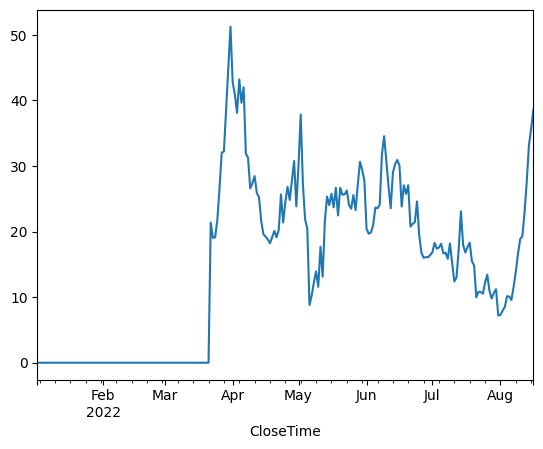

In [16]:
(positions*prices).sum(axis=1).plot()

In [14]:
ps.corr()

,ADAUSDT,BNBBTC,BNBETH,BTCUSDT,ETHBTC,ETHUSDT
ADAUSDT,1.000000,0.055527,-0.033601,0.718356,0.227776,0.308230
BNBBTC,0.055527,1.000000,0.328410,-0.084118,0.129524,-0.017407
BNBETH,-0.033601,0.328410,1.000000,-0.125789,-0.079147,-0.167841
BTCUSDT,0.718356,-0.084118,-0.125789,1.000000,0.309031,0.517002
ETHBTC,0.227776,0.129524,-0.079147,0.309031,1.000000,0.241706
ETHUSDT,0.308230,-0.017407,-0.167841,0.517002,0.241706,1.000000


<AxesSubplot:xlabel='CloseTime'>

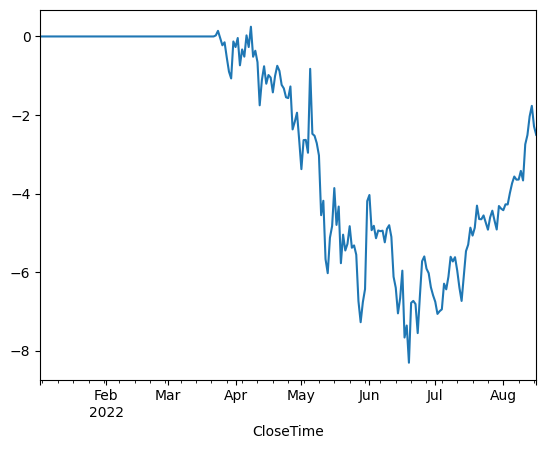

In [15]:
ps.sum(axis=1).cumsum().plot()